# **<center><font style="color:rgb(100,109,254)">Human Action Recognition in Videos using Keras (CNN + LSTM)</font> </center>**


## **<font style="color:rgb(134,19,348)"> Outline </font>**

- **`Step 1:` Download and Visualize the Data with its Labels**

- **`Step 2:` Preprocess the Dataset**

- **`Step 3:` Split the Data into Train and Test Set**

- **`Step 4:` Implement the ConvLSTM Approach**

    - **`Step 4.1:` Construct the Model**
    
    - **`Step 4.2:` Compile & Train the Model**
    
    - **`Step 4.3:` Plot Model’s Loss & Accuracy Curves**

- **`Step 5:` implement the LRCN Approach**

    - **`Step 5.1:` Construct the Model**
    
    - **`Step 5.2:` Compile & Train the Model**
    
    - **`Step 5.3:` Plot Model’s Loss & Accuracy Curves**
    
- **`Step 6:` Test the Best Performing Model on YouTube videos**



### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

In [ ]:
import os
import cv2
# import pafy
import math
import random
import pandas as pd
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## **<font style="color:rgb(134,19,348)">Step 1: Download and Visualize the Data with its Labels</font>**
UCF50 - Action Recognition Dataset

*   **`50`** Danh mục hành động

*   **`133`** Số video trung bình mỗi hành động

*   **`26`** Số khung hình trung bình mỗi video


In [ ]:

# # Download Dataset
# !wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

# #Extract the Dataset
# !unrar x UCF50.rar

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
#!unzip '/content/drive/MyDrive/Dataset/UCF50.zip' -d '/content/drive/MyDrive/Dataset/UCF50'

['Swing', 'TaiChi', 'VolleyballSpiking', 'Biking', 'Billiards', 'Drumming', 'HorseRace', 'PlayingGuitar', 'PlayingPiano', 'PullUps', 'Punch', 'SoccerJuggling', 'Skijet', 'PushUps']


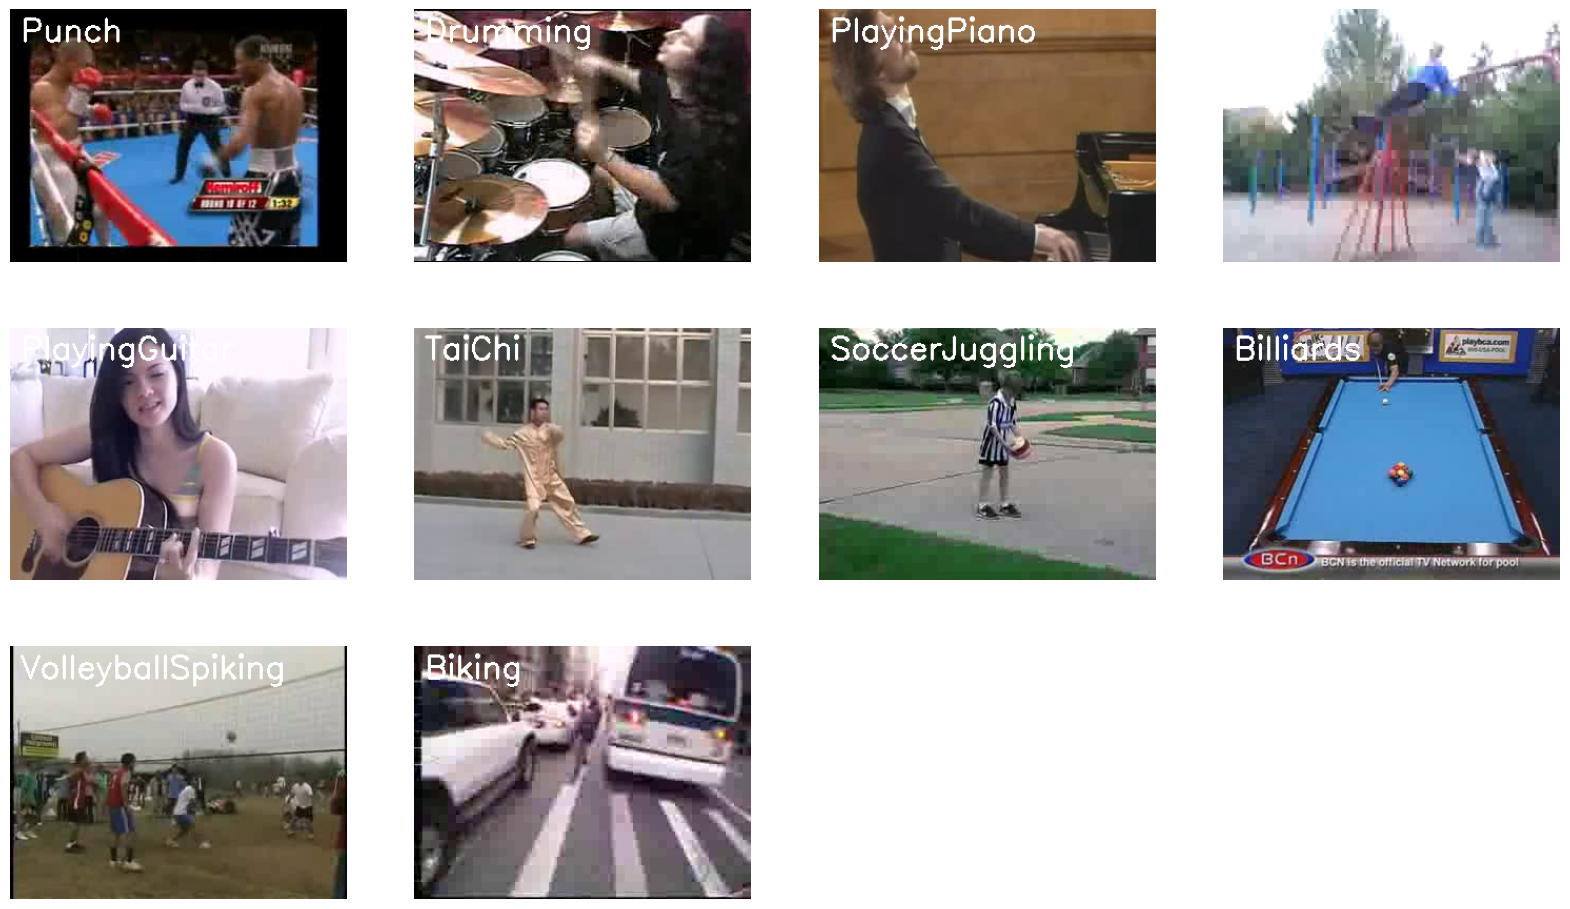

In [ ]:
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('/content/drive/MyDrive/Dataset/UCF50/UCF50')
print(all_classes_names)
random_range = random.sample(range(len(all_classes_names)), 10)


for counter, random_index in enumerate(random_range, 1):


    selected_class_Name = all_classes_names[random_index]


    video_files_names_list = os.listdir(f'/content/drive/MyDrive/Dataset/UCF50/UCF50/{selected_class_Name}')

    selected_video_file_name = random.choice(video_files_names_list)

    video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/Dataset/UCF50/UCF50/{selected_class_Name}/{selected_video_file_name}')

    _, bgr_frame = video_reader.read()

    video_reader.release()

    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**



In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 10

DATASET_DIR = "/content/drive/MyDrive/Dataset/UCF50/UCF50"

CLASSES_LIST = ["Billiards","SoccerJuggling", "Swing", "HorseRace","PlayingPiano","PushUps","Skijet","Drumming"]



### **<font style="color:rgb(134,19,348)">Create a Function to Extract, Resize & Normalize Frames</font>**



In [ ]:
def frames_extraction(video_path):


    frames_list = []

    video_reader = cv2.VideoCapture(video_path)

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    video_reader.release()

    return frames_list

### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**


In [ ]:
def create_dataset():



    features = []
    labels = []
    video_files_paths = []


    for class_index, class_name in enumerate(CLASSES_LIST):


        print(f'Extracting Data of Class: {class_name}')


        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))


        for file_name in files_list:


            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)


            frames = frames_extraction(video_file_path)


            if len(frames) == SEQUENCE_LENGTH:


                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [ ]:
# Create the dataset.
X, y, video_files_paths = create_dataset()

one_hot_encoded_labels = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, one_hot_encoded_labels,
                                                    test_size = 0.2, shuffle = True,
                                                    random_state = 42)

Extracting Data of Class: Billiards
Extracting Data of Class: SoccerJuggling
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace
Extracting Data of Class: PlayingPiano
Extracting Data of Class: PushUps
Extracting Data of Class: Skijet
Extracting Data of Class: Drumming


## **<font style="color:rgb(134,19,348)">Step 3: Split the Data into Train and Test Set</font>**



In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, one_hot_encoded_labels,
                                                    test_size = 0.2, shuffle = True,
                                                    random_state = 42)

In [ ]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

## **<font style="color:rgb(134,19,348)">Step 4: Implement the ConvLSTM Approach</font>**

### **<font style="color:rgb(134,19,348)">Step 4.1: Construct the Model</font>**


 [**`ConvLSTM2D`**](https://keras.io/api/layers/recurrent_layers/conv_lstm2d) recurrent layers

**Lớp ConvLSTM2D:**

* Đây là lớp lặp ConvLSTM2D (Convolutional LSTM 2D) trong Keras được sử dụng để xử lý các chuỗi ảnh (video) 2 chiều.
* Lớp này cần hai tham số chính:
    * **Số bộ lọc (filters):** Xác định số lượng bộ lọc để trích xuất các đặc điểm khác nhau từ ảnh.
    * **Kích thước kernel (kernel size):** Xác định kích thước của bộ lọc hình vuông sẽ được di chuyển trên ảnh để trích xuất các đặc điểm.
* Đầu ra của lớp ConvLSTM2D là một tensor 4 chiều (batch_size, timesteps, height, width), nơi:
    * `batch_size` là số lượng mẫu trong mỗi lần tính toán.
    * `timesteps` là số khung hình trong chuỗi ảnh.
    * `height` và `width` là chiều cao và rộng của khung hình.

**Kiến trúc mô hình:**

* **MaxPooling3D:** Lớp này được sử dụng sau mỗi lớp ConvLSTM2D để giảm kích thước của tensor đầu ra, giảm bớt tính toán và giảm nguy cơ quá khớp (overfitting).
* **Dropout:** Lớp này ngẫu nhiên bỏ qua một số kết nối thần kinh trong quá trình huấn luyện, giúp ngăn ngừa quá khớp.
* **Đơn giản và ít tham số:** Mô hình được thiết kế đơn giản với số lượng tham số huấn luyện ít. Điều này phù hợp với việc xử lý một tập dữ liệu nhỏ, không cần mô hình phức tạp.
* **Cuối cùng của mô hình:** Đầu ra của ConvLSTM2D được làm phẳng (flatten) thành một vector để đưa vào lớp Dense (Dense layer). Lớp Dense này có hàm kích hoạt softmax, cho ra xác suất thuộc về từng loại hành động.


## Input và Output Vector của Mô Hình ConvLSTM2D :

**Input Vector:**

* Có dạng tensor 4 chiều: `(batch_size, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)`
* Mô tả:
    * `batch_size`: Số lượng mẫu trong mỗi lần tính toán (thường là giá trị nhỏ, ví dụ 8 hoặc 16).
    * `SEQUENCE_LENGTH`: Số frame ảnh trong chuỗi video (ví dụ 32, 64).
    * `IMAGE_HEIGHT`: Chiều cao của mỗi frame ảnh (ví dụ 128, 256).
    * `IMAGE_WIDTH`: Chiều rộng của mỗi frame ảnh (ví dụ 128, 256).
    * `3`: Số kênh màu của mỗi frame ảnh (RGB).

**Output Vector:**

* Có dạng tensor 1 chiều: `(batch_size, len(CLASSES_LIST))`
* Mô tả:
    * `batch_size`: Số lượng mẫu trong mỗi lần tính toán (giống như input).
    * `len(CLASSES_LIST)`: Số lượng các loại hành động mà mô hình có thể phân loại.
* Mỗi phần tử trong tensor output đại diện cho xác suất thuộc về một loại hành động cụ thể cho từng mẫu trong batch.

**Ví dụ:**

* Giả sử `batch_size` là 8, `SEQUENCE_LENGTH` là 10, `IMAGE_HEIGHT` là 128, `IMAGE_WIDTH` là 128 và có 5 loại hành động.
* Input vector sẽ có kích thước:`(8, 32, 128, 128, 3)`.
* Output vector sẽ có kích thước: `(5,)`. Mỗi phần tử trong output vector của một mẫu

Giả sử output là [0.9, 0.1, 0.0, 0.0, 0.0] Mỗi giá trị sẽ thể hiện xác suất dự đoán cho 10 khung hình tương ứng với class_list






In [ ]:
def create_convlstm_model():


    model = Sequential()


    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))


    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    model.summary()

    return model

In [ ]:
convlstm_model = create_convlstm_model()

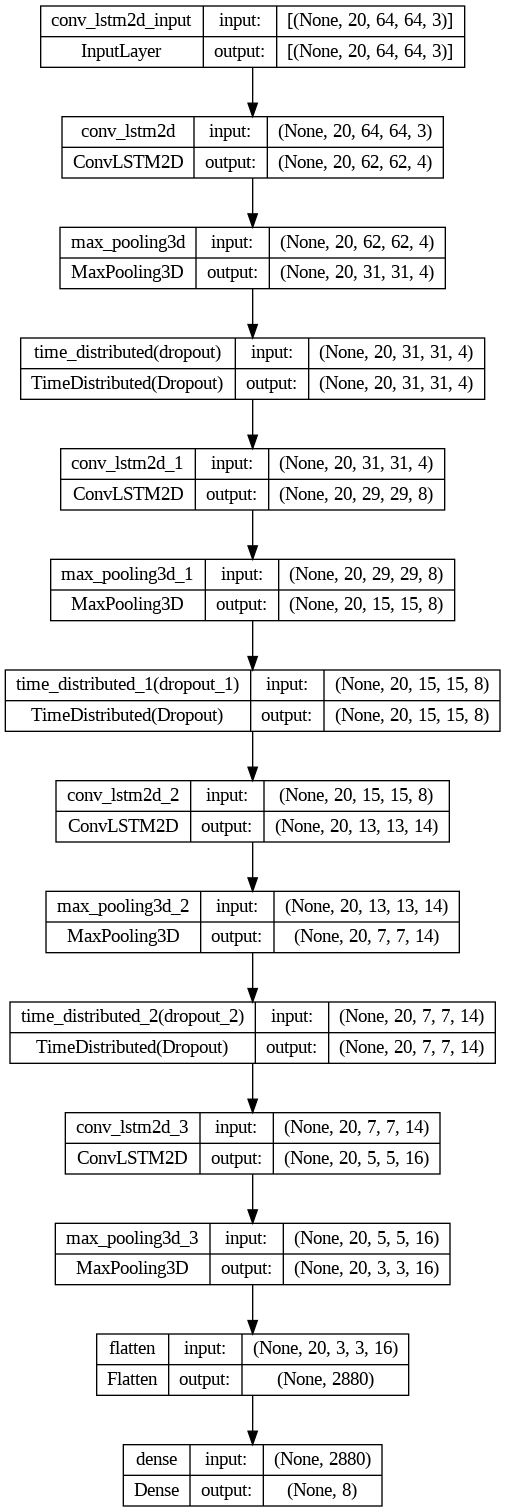

In [ ]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 4.2: Compile & Train the Model</font>**


In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)
convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = X_train, y = y_train, epochs = 20, batch_size = 4,
                                                     shuffle = True, validation_split = 0.2,
                                                     callbacks = [early_stopping_callback])

Epoch 1/20
171/171 [==============================] - 78s 359ms/step - loss: 1.4909 - accuracy: 0.3704 - val_loss: 1.1294 - val_accuracy: 0.4795
Epoch 2/20
171/171 [==============================] - 60s 353ms/step - loss: 0.9874 - accuracy: 0.6018 - val_loss: 0.7625 - val_accuracy: 0.7368
Epoch 3/20
171/171 [==============================] - 62s 360ms/step - loss: 0.7716 - accuracy: 0.7013 - val_loss: 1.3526 - val_accuracy: 0.6257
Epoch 4/20
171/171 [==============================] - 61s 356ms/step - loss: 0.6182 - accuracy: 0.7804 - val_loss: 0.7496 - val_accuracy: 0.7076
Epoch 5/20
171/171 [==============================] - 59s 345ms/step - loss: 0.3950 - accuracy: 0.8521 - val_loss: 1.0427 - val_accuracy: 0.7018
Epoch 6/20
171/171 [==============================] - 61s 359ms/step - loss: 0.4253 - accuracy: 0.8492 - val_loss: 0.5963 - val_accuracy: 0.7778
Epoch 7/20
171/171 [==============================] - 62s 364ms/step - loss: 0.3164 - accuracy: 0.8902 - val_loss: 0.4498 - val_ac

In [ ]:
model_evaluation_history = convlstm_model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 113ms/step - loss: 0.4271 - accuracy: 0.8692


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history


date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

convlstm_model.save(model_file_name)

  saving_api.save_model(



### **<font style="color:rgb(134,19,348)">Step 4.3: Plot Model’s Loss & Accuracy Curves</font>**




In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

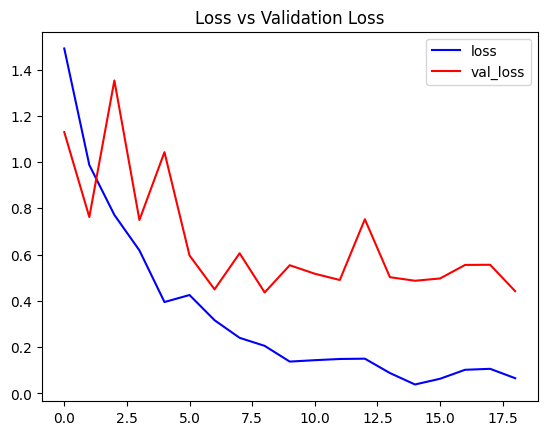

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Loss vs Validation Loss')

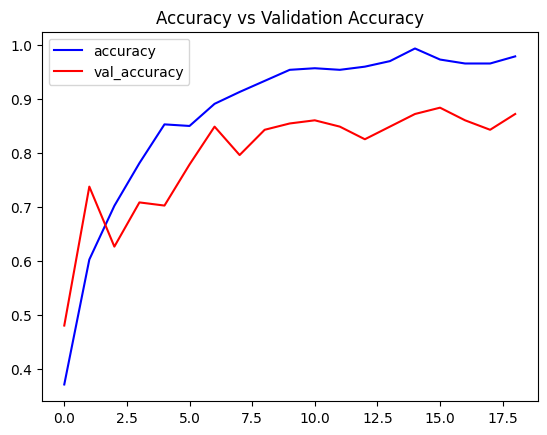

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Accuracy vs Validation Accuracy')

In [ ]:
y_pred = convlstm_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes))

7/7 [==============================] - 2s 89ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        31
           1       0.87      0.79      0.83        34
           2       0.80      0.80      0.80        30
           3       0.85      0.88      0.86        25
           4       0.89      0.85      0.87        20
           5       0.73      0.89      0.80        18
           6       0.88      0.88      0.88        24
           7       0.91      0.91      0.91        32

    accuracy                           0.87       214
   macro avg       0.87      0.87      0.87       214
weighted avg       0.87      0.87      0.87       214



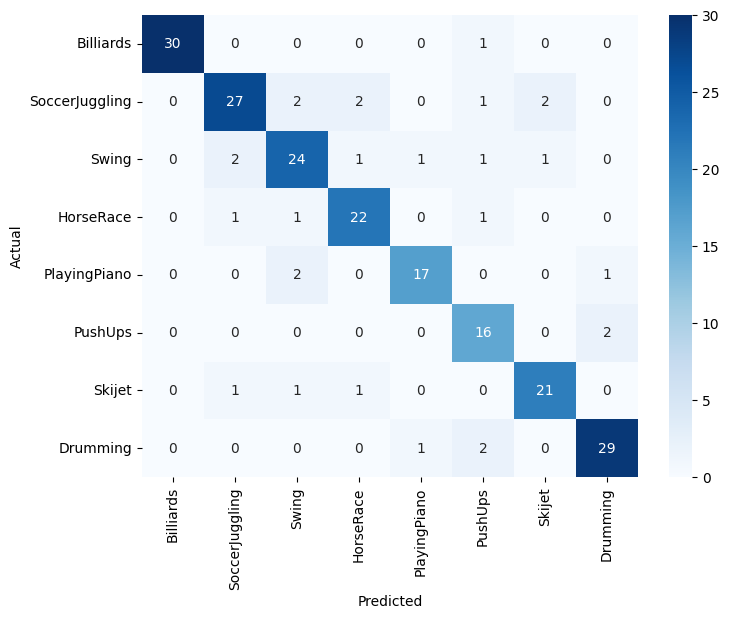

In [ ]:

import seaborn as sns

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Hai cách tiếp cận khác nhau để thực hiện nhận dạng hành động trong video:

**1. Sử dụng các mô hình riêng biệt ConvLSTM:**

* **Mô hình CNN:** Được sử dụng để trích xuất các đặc trưng không gian từ từng khung hình video, chẳng hạn như màu sắc, hình dạng và chuyển động.
* **Mô hình LSTM:** Được sử dụng để mô hình chuỗi thời gian các đặc trưng không gian đã được trích xuất bởi CNN, nhằm dự đoán hành động đang diễn ra.

**2. Sử dụng LRCN:**

* Là một mô hình kết hợp các lớp Convolutional và LSTM trong một mô hình duy nhất.
* Các lớp Convolutional trích xuất các đặc trưng không gian từ từng khung hình.
* Các đặc trưng này được đưa trực tiếp vào các lớp LSTM tại từng bước thời gian để mô hình chuỗi thời gian.

**Điểm khác biệt chính:**

* **LRCN học các đặc trưng spatiotemporal trực tiếp trong quá trình huấn luyện tổng thể, trong khi cách tiếp cận sử dụng các mô hình riêng biệt yêu cầu quá trình đào tạo riêng cho CNN và LSTM.**
* **LRCN có khả năng học các mối quan hệ phức tạp giữa các đặc trưng không gian và thời gian, có thể dẫn đến độ chính xác cao hơn.**
* **LRCN có thể phức tạp hơn và đòi hỏi nhiều tài nguyên hơn so với cách tiếp cận sử dụng các mô hình riêng biệt.**

**Tác giả lựa chọn thực hiện LRCN trong bước này vì mong muốn tận dụng khả năng học các đặc trưng spatiotemporal trực tiếp và đạt độ chính xác cao hơn.**

Hy vọng giải thích này giúp bạn hiểu rõ hơn về đoạn văn và hai cách tiếp cận khác nhau để nhận dạng hành động trong video.


## **<font style="color:rgb(134,19,348)">Step 5: Implement the LRCN Approach</font>**

##  Bước 5: Xây dựng mô hình LRCN một cách dễ hiểu

**Tưởng tượng video như một bộ bài các ảnh (frame).**

1. **Lấy từng ảnh trong bộ bài:** Giống như xem từng lá bài, chúng ta đưa từng frame ảnh vào **Conv - Convolutional layers**. Mục đích là trích xuất những chi tiết quan trọng trong ảnh, ví dụ như hình dáng, màu sắc, chuyển động. Giống như bạn tìm kiếm chi tiết quan trọng để nhận dạng lá bài.
2. **Nhớ những chi tiết quan trọng:** Sau khi Conv xử lý từng ảnh, kết quả được **LSTM - Long Short-Term Memory layer** thu thập và ghi nhớ. LSTM giống như bộ nhớ của bạn, ghi nhớ những chi tiết quan trọng của từng ảnh liên tiếp nhau.
3. **Hiểu từng ảnh và cả chuỗi ảnh:** LSTM không chỉ nhớ riêng từng ảnh, mà còn hiểu mối liên hệ giữa chúng. Giống như bạn có thể hiểu câu chuyện kể qua bộ bài, LSTM học hỏi mối liên hệ giữa các ảnh trong video để hiểu hành động đang diễn ra.
4. **Dự đoán hành động:** Cuối cùng, dựa trên những gì đã học được, LSTM dự đoán hành động đang diễn ra trong video. Giống như bạn nhìn bộ bài và đoán xem nó kể về điều gì.

**Tại sao dùng LRCN thay vì tách CNN và LSTM?**

- **Hiệu quả hơn:** LRCN học trực tiếp mối liên hệ không gian và thời gian, giúp hiểu video tốt hơn. Giống như xem cả bộ bài thay vì chỉ từng lá riêng lẻ.
- **Trực tiếp hơn:** Các bước trích xuất chi tiết và hiểu video diễn ra liền mạch trong một mô hình, giảm phức tạp.

**TimeDistributed là gì?**

- LRCN xử lý từng frame riêng lẻ, TimeDistributed giúp áp dụng cùng một xử lý cho tất cả frame. Giống như bạn nhìn và hiểu từng lá bài trong bộ bài.

**Tóm lại:**

- ConvLSTM: Xử lý thông tin không gian và thời gian đồng thời trong các khối ConvLSTM2D.
- LRCN: Xử lý thông tin không gian và thời gian tách biệt, với các lớp convolutional 2D xử lý thông tin không gian trước, sau đó lớp LSTM xử lý thông tin thời gian.
- TimeDistributed giúp xử lý toàn bộ video cùng lúc, hiệu quả hơn.



### **<font style="color:rgb(134,19,348)">Step 5.1: Construct the Model</font>**



In [ ]:
def create_LRCN_model():


    model = Sequential()


    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    # TimeDistributed(Conv2D(...)): Trích xuất các đặc điểm
    # không gian từ từng khung hình bằng các lớp Convolution 2D (Conv2D).
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))


    model.summary()


    return model

In [ ]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

In [ ]:
# plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Step 5.2: Compile & Train the Model</font>**



In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x = X_train, y = y_train, epochs = 30, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/30
86/86 [==============================] - 7s 38ms/step - loss: 1.9944 - accuracy: 0.1991 - val_loss: 1.7117 - val_accuracy: 0.3743
Epoch 2/30
86/86 [==============================] - 2s 18ms/step - loss: 1.5384 - accuracy: 0.3968 - val_loss: 1.3948 - val_accuracy: 0.4503
Epoch 3/30
86/86 [==============================] - 1s 16ms/step - loss: 1.2742 - accuracy: 0.4949 - val_loss: 1.5014 - val_accuracy: 0.3918
Epoch 4/30
86/86 [==============================] - 1s 16ms/step - loss: 1.1751 - accuracy: 0.5652 - val_loss: 1.0349 - val_accuracy: 0.6140
Epoch 5/30
86/86 [==============================] - 1s 16ms/step - loss: 1.0358 - accuracy: 0.6032 - val_loss: 1.1414 - val_accuracy: 0.6374
Epoch 6/30
86/86 [==============================] - 1s 16ms/step - loss: 0.9392 - accuracy: 0.6530 - val_loss: 0.9838 - val_accuracy: 0.6199
Epoch 7/30
86/86 [==============================] - 1s 15ms/step - loss: 0.7686 - accuracy: 0.7233 - val_loss: 0.8806 - val_accuracy: 0.6608
Epoch 8/30
86

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**


In [ ]:
model_evaluation_history = LRCN_model.evaluate(X_test, y_test)

7/7 [==============================] - 1s 76ms/step - loss: 0.2549 - accuracy: 0.9346


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**


In [ ]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history


date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

  saving_api.save_model(



### **<font style="color:rgb(134,19,348)">Step 5.3: Plot Model’s Loss & Accuracy Curves</font>**

Now we will utilize the function **`plot_metric()`** we had created above to visualize the training and validation metrics of this model.

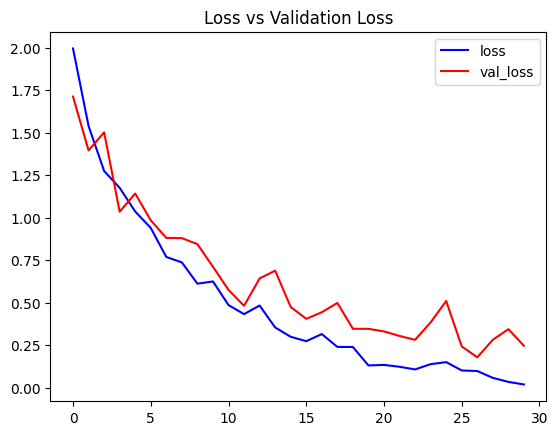

In [ ]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Loss vs Validation Loss')

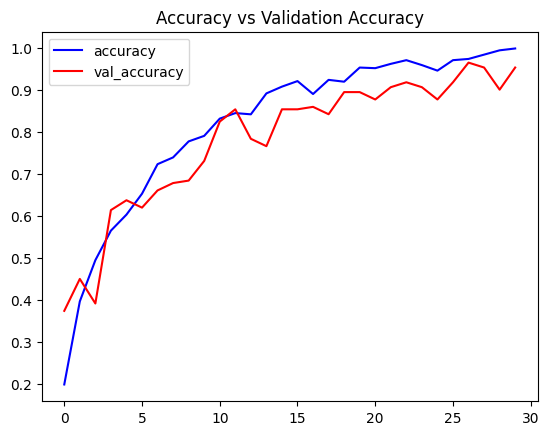

In [ ]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Accuracy vs Validation Accuracy')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred = LRCN_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes))

7/7 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       0.97      0.91      0.94        34
           2       0.90      0.90      0.90        30
           3       0.86      0.96      0.91        25
           4       0.89      0.85      0.87        20
           5       0.89      0.94      0.92        18
           6       1.00      1.00      1.00        24
           7       0.94      0.91      0.92        32

    accuracy                           0.93       214
   macro avg       0.93      0.93      0.93       214
weighted avg       0.94      0.93      0.93       214



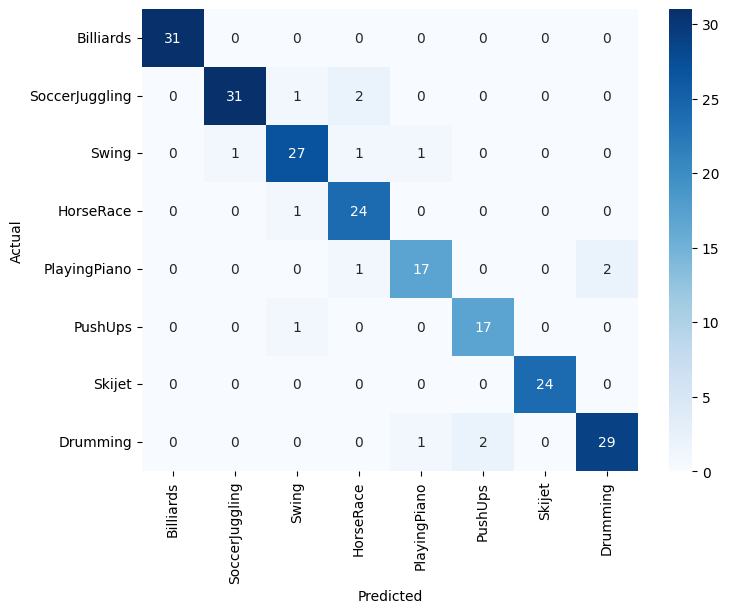

In [ ]:

import seaborn as sns

confusion_mtx = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=CLASSES_LIST, yticklabels=CLASSES_LIST)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## **<font style="color:rgb(134,19,348)">Step 6: Test the Best Performing Model on YouTube videos</font>**

From the results, it seems that the LRCN model performed significantly well for a small number of classes. so in this step, we will put the `LRCN` model to test on some youtube videos.

### **<font style="color:rgb(134,19,348)">Create a Function to Download YouTube Videos:</font>**

We will create a function **`download_youtube_videos()`** to download the YouTube videos first using **`pafy`** library. The library only requires a URL to a video to download it along with its associated metadata like the title of the video.

In [ ]:
!pip install pytube


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.3 MB/s eta 0:00:00


### **<font style="color:rgb(134,19,348)">Download a Test Video:</font>**

Now we will utilize the function **`download_youtube_video()`** created above to download a youtube video on which the `LRCN` model will be tested.

In [ ]:
import pytube

def download_youtube_video(url, output_path):
    try:
        youtube = pytube.YouTube(url)
        video = youtube.streams.get_highest_resolution()
        title = video.title
        output_file_path = f"{output_path}/{title}.mp4"
        video.download(output_path)
        return title
    except Exception as e:
        print("Error: ", str(e))
        return None

In [ ]:

test_videos_directory = 'test_videos'
os.makedirs(test_videos_directory, exist_ok=True)

# video_url = 'https://www.youtube.com/shorts/9tDoyzL9uwQ'
video_url = 'https://youtu.be/nbq5_hb9zqQ'

video_title = download_youtube_video(video_url, test_videos_directory)

input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'
# print(input_video_file_path)

### **<font style="color:rgb(134,19,348)">Create a Function To Perform Action Recognition on Videos</font>**

## Giải thích chi tiết hàm `predict_on_video`:

Hàm `predict_on_video` này sử dụng mô hình LRCN đã được huấn luyện để dự đoán hành động diễn ra trong một video. Nó thực hiện các bước sau:

**1. Khởi tạo các đối tượng VideoCapture và VideoWriter:**

* `video_reader`: Dùng để đọc khung hình từ video đầu vào.
* `video_writer`: Dùng để ghi khung hình dự đoán với nhãn hành động vào video mới.

**2. Cài đặt các thông số:**

* `SEQUENCE_LENGTH`: Số lượng khung hình cố định dùng để dự đoán một hành động(20).
* `original_video_width` và `original_video_height`: Chiều rộng và cao ban đầu của video.

**3. Xử lý từng khung hình của video:**

* Đọc mỗi khung hình từ `video_reader`.
* Kiểm tra xem đọc khung hình thành công hay không.
* Resize khung hình về kích thước cố định (ví dụ 128x128).
* Chuẩn hóa giá trị pixel của khung hình về khoảng [0, 1].
* Thêm khung hình đã xử lý vào hàng đợi `frames_queue` (giới hạn tối đa `SEQUENCE_LENGTH`).

**4. Dự đoán hành động khi đủ khung hình:**

* Khi hàng đợi `frames_queue` đủ `SEQUENCE_LENGTH` khung hình, chuyển thành dạng tensor 4 chiều và đưa vào mô hình LRCN.
* Lấy kết quả dự đoán: một mảng xác suất cho từng loại hành động.
* Chọn lớp có xác suất cao nhất, từ đó lấy tên hành động tương ứng trong `CLASSES_LIST`.

**5. Ghi hành động dự đoán lên video:**

* Viết tên hành động dự đoán lên góc trên cùng của khung hình hiện tại.
* Ghi khung hình đã có tên hành động vào video đầu ra bằng `video_writer`.



**Tóm lại:**

Hàm này xử lý từng khung hình video, tạo thành đoạn video ngắn gồm `SEQUENCE_LENGTH` khung, dự đoán hành động bằng LRCN cho đoạn video ngắn này, sau đó ghi lại khung hình gốc có thêm tên hành động dự đoán vào video đầu ra.


In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):


    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    predicted_class_name = ''

    while video_reader.isOpened():

        _, frame = video_reader.read()

        if not _:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:

            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]

        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [ ]:
def predict_on_video_conv(video_file_path, output_file_path, SEQUENCE_LENGTH):


    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    predicted_class_name = ''

    while video_reader.isOpened():

        _, frame = video_reader.read()

        if not _:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:

            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]

        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

### **<font style="color:rgb(134,19,348)">Perform Action Recognition on the Test Video</font>**

Now we will utilize the function **`predict_on_video()`** created above to perform action recognition on the test video we had downloaded using the function **`download_youtube_video()`** and display the output video with the predicted action overlayed on it.

In [ ]:
output_video_file_path = f'{test_videos_directory}/{video_title}-LRCN.mp4'

predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

#VideoFileClip(output_video_file_path, audio=False, target_resolution=(600,None)).ipython_display()
print("Predict Success")

1/1 [==============================] - 0s 19ms/step
Predict Success


In [ ]:
output_video_file_path = f'{test_videos_directory}/{video_title}-conv.mp4'

predict_on_video_conv(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

#VideoFileClip(output_video_file_path, audio=False, target_resolution=(600,None)).ipython_display()
print("Predict Success")

1/1 [==============================] - 0s 54ms/step
Predict Success


### **<font style="color:rgb(134,19,348)">Create a Function To Perform a Single Prediction on Videos</font>**


## Giải thích hàm `predict_single_action`:

Hàm này thực hiện dự đoán hành động **duy nhất** cho toàn bộ video bằng cách trích xuất các khung hình phân bổ đều và đưa vào mô hình LRCN. Điều này giúp tiết kiệm tính toán và thời gian khi video chỉ chứa một hành động.

**Các bước thực hiện:**

1. **Khởi tạo đối tượng VideoCapture:** Dùng để đọc video.
2. **Lấy kích thước video:** Chiều rộng và cao.
3. **Tạo danh sách khung hình:** Lưu trữ các khung hình sẽ trích xuất.
4. **Lấy số khung hình video:** Tổng số khung hình trong video.
5. **Tính khoảng cách giữa các khung hình trích xuất:** Số khung hình bỏ qua giữa mỗi khung được trích xuất.
6. **Lặp qua số khung hình cố định:**
    * **Đặt vị trí khung hình hiện tại:** Dựa vào bộ đếm khung hình và khoảng cách.
    * **Đọc khung hình:** Kiểm tra nếu đọc thành công.
    * **Resize khung hình:** Đổi kích thước về kích thước cố định.
    * **Chuẩn hóa khung hình:** Chia từng pixel cho 255 để nằm trong khoảng [0, 1].
    * **Thêm khung hình vào danh sách:** Lưu trữ khung hình đã xử lý.
7. **Dự đoán hành động:** Dùng mô hình LRCN để dự đoán với danh sách khung hình.
8. **Xác định hành động có xác suất cao nhất:** Dựa vào kết quả dự đoán.
9. **Lấy tên hành động tương ứng:** Từ danh sách CLASSES_LIST.
10. **Hiển thị hành động và độ tin cậy:** In ra tên hành động và xác suất dự đoán cao nhất.
11. **Giải phóng VideoCapture:** Đóng kết nối với video.

**Điểm quan trọng:**

* Hàm này trích xuất các khung hình đều đặn (theo khoảng cách `skip_frames_window`) để đảm bảo bao phủ toàn bộ video.
* Hàm chỉ dự đoán một lần cho toàn bộ video, tiết kiệm thời gian khi video chứa một hành động.
* Hàm in ra tên hành động dự đoán và độ tin cậy để đánh giá kết quả.



In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):


    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames_list = []

    predicted_class_name = ''

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    print(video_frames_count)
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        _, frame = video_reader.read()

        if not _:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]

    predicted_label = np.argmax(predicted_labels_probabilities)

    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    video_reader.release()


### **<font style="color:rgb(134,19,348)">Perform Single Prediction on a Test Video</font>**



In [ ]:
video_title = download_youtube_video('https://www.youtube.com/shorts/A-IZ7vvZHIs', test_videos_directory)

input_video_file_path = f'{test_videos_directory}/{video_title}.mp4'

#predict_single_action(input_video_file_path, SEQUENCE_LENGTH)

#VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

In [ ]:
predict_single_action(input_video_file_path, SEQUENCE_LENGTH)


0


ValueError: ignored